In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from PIL import Image
from random import sample
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input as vgg_preprocess
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input as resnet_preprocess
from tensorflow.keras.applications.xception import Xception, preprocess_input as xception_preprocess
from tensorflow.keras.models import Model
from pathlib import Path
Image.LOAD_TRUNCATED_IMAGES = True
import requests
from io import BytesIO
import os

In [5]:
# Read the data files
listing_data = pd.read_csv("../FashionImageDataset_FarFetch/current_farfetch_listings.csv")

In [6]:
listing_data.head()

,Unnamed: 0,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,...,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.installmentsLabel,priceInfo.isOnSale,shortDescription,stockTotal
0,0,NaN,8360,Miu Miu,women,True,13415450,https://cdn-images.farfetch-contents.com/13/41...,https://cdn-images.farfetch-contents.com/13/41...,False,...,SGD,NaN,1080,"$1,080","$1,080",1080,NaN,False,logo print strap sandals,130
1,1,"[{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...",2049368,Self-Portrait,women,True,13784566,https://cdn-images.farfetch-contents.com/13/78...,https://cdn-images.farfetch-contents.com/13/78...,False,...,SGD,20% Off,392,$392,$490,490,NaN,True,embroidered midi dress,14
2,2,NaN,15514,Fendi,women,True,13377441,https://cdn-images.farfetch-contents.com/13/37...,https://cdn-images.farfetch-contents.com/13/37...,False,...,SGD,NaN,1245,"$1,245","$1,245",1245,NaN,False,FendiMania sock style sneakers,68
3,3,"[{'scaleId': 0, 'size': 'One Size'}]",49486,A.P.C.,women,False,13744082,https://cdn-images.farfetch-contents.com/13/74...,https://cdn-images.farfetch-contents.com/13/74...,False,...,SGD,20% Off,308,$308,$385,385,NaN,True,top zip wallet,1
4,4,NaN,34624,Prada,women,True,13668256,https://cdn-images.farfetch-contents.com/13/66...,https://cdn-images.farfetch-contents.com/13/66...,False,...,SGD,NaN,1248,"$1,248","$1,248",1248,NaN,False,slingback 65 pumps,78


In [7]:
# Check the shape of data (num_rows, num_colums)
listing_data.shape

(188817, 23)

In [8]:
# drop the unnames: 0 column
listing_data.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
# Check for dtypes
listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188817 entries, 0 to 188816
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   availableSizes                   162711 non-null  object 
 1   brand.id                         188817 non-null  int64  
 2   brand.name                       188817 non-null  object 
 3   gender                           188817 non-null  object 
 4   hasSimilarProducts               188817 non-null  bool   
 5   id                               188817 non-null  int64  
 6   images.cutOut                    188817 non-null  object 
 7   images.model                     188817 non-null  object 
 8   isCustomizable                   188817 non-null  bool   
 9   merchandiseLabel                 56441 non-null   object 
 10  merchandiseLabelField            188817 non-null  object 
 11  merchantId                       188817 non-null  int64  
 12  pr

In [10]:
# Drop priceInfo.installmentsLabel
listing_data.drop('priceInfo.installmentsLabel', axis=1, inplace=True)

In [11]:
# Check for % of null values
listing_data.isnull().sum() * 100 / listing_data.shape[0] 

availableSizes                     13.826086
brand.id                            0.000000
brand.name                          0.000000
gender                              0.000000
hasSimilarProducts                  0.000000
id                                  0.000000
images.cutOut                       0.000000
images.model                        0.000000
isCustomizable                      0.000000
merchandiseLabel                   70.108094
merchandiseLabelField               0.000000
merchantId                          0.000000
priceInfo.currencyCode              0.000000
priceInfo.discountLabel            63.834295
priceInfo.finalPrice                0.000000
priceInfo.formattedFinalPrice       0.000000
priceInfo.formattedInitialPrice     0.000000
priceInfo.initialPrice              0.000000
priceInfo.isOnSale                  0.000000
shortDescription                    0.000000
stockTotal                          0.000000
dtype: float64

In [12]:
# Analyse the null variables
listing_data[~listing_data['merchandiseLabel'].isnull()].head()

,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabel,...,merchantId,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
9,"[{'scaleId': 0, 'size': 'XXS'}, {'scaleId': 0,...",1504165,Rejina Pyo,women,True,13777585,https://cdn-images.farfetch-contents.com/13/77...,https://cdn-images.farfetch-contents.com/13/77...,False,New Season,...,9359,SGD,NaN,989,$989,$989,989,False,Blake herringbone midi dress,16
11,"[{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...",2747,Chloé,women,True,13704528,https://cdn-images.farfetch-contents.com/13/70...,https://cdn-images.farfetch-contents.com/13/70...,False,New Season,...,9359,SGD,NaN,1790,"$1,790","$1,790",1790,False,pussy-bow rose-jacquard blouse,14
13,"[{'scaleId': 0, 'size': 'L'}, {'scaleId': 0, '...",168996,Pleats Please By Issey Miyake,women,True,14107224,https://cdn-images.farfetch-contents.com/14/10...,https://cdn-images.farfetch-contents.com/14/10...,False,New Season,...,9359,SGD,NaN,657,$657,$657,657,False,pleated midi dress,13
15,NaN,769627,Burberry,women,True,13970008,https://cdn-images.farfetch-contents.com/13/97...,https://cdn-images.farfetch-contents.com/13/97...,False,New Season,...,9359,SGD,NaN,1000,"$1,000","$1,000",1000,False,Margrette 50mm cow print pumps,10
18,"[{'scaleId': 0, 'size': 'XS'}, {'scaleId': 0, ...",2765,Alexander McQueen,women,True,13951735,https://cdn-images.farfetch-contents.com/13/95...,https://cdn-images.farfetch-contents.com/13/95...,False,New Season,...,9359,SGD,NaN,3330,"$3,330","$3,330",3330,False,tie-neck houndstooth midi-dress,2


In [13]:
# Check for the categories in merchandiseLabel
listing_data['merchandiseLabel'].value_counts()

New Season              41469
Positively Conscious    12324
Permanent Collection     1275
Seasonal Pick             741
Exclusive                 632
Name: merchandiseLabel, dtype: int64

In [14]:
# Drop the column merchandiseLabel
listing_data.drop('merchandiseLabel', axis=1, inplace=True)

In [15]:
# Analysing priceInfo.discountLabel
listing_data[listing_data['priceInfo.discountLabel'].isnull()].head()

,availableSizes,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
0,NaN,8360,Miu Miu,women,True,13415450,https://cdn-images.farfetch-contents.com/13/41...,https://cdn-images.farfetch-contents.com/13/41...,False,NoTag,9359,SGD,NaN,1080,"$1,080","$1,080",1080,False,logo print strap sandals,130
2,NaN,15514,Fendi,women,True,13377441,https://cdn-images.farfetch-contents.com/13/37...,https://cdn-images.farfetch-contents.com/13/37...,False,NoTag,9140,SGD,NaN,1245,"$1,245","$1,245",1245,False,FendiMania sock style sneakers,68
4,NaN,34624,Prada,women,True,13668256,https://cdn-images.farfetch-contents.com/13/66...,https://cdn-images.farfetch-contents.com/13/66...,False,NoTag,9339,SGD,NaN,1248,"$1,248","$1,248",1248,False,slingback 65 pumps,78
6,"[{'scaleId': 0, 'size': 'One Size'}]",25354,Gucci,women,True,12562558,https://cdn-images.farfetch-contents.com/12/56...,https://cdn-images.farfetch-contents.com/12/56...,False,NoTag,10952,SGD,NaN,3740,"$3,740","$3,740",3740,False,Green Dionysus GG small velvet shoulder bag,61
7,"[{'scaleId': 0, 'size': 'One Size'}]",1025204,MCM,women,True,13768073,https://cdn-images.farfetch-contents.com/13/76...,https://cdn-images.farfetch-contents.com/13/76...,False,NoTag,9913,SGD,NaN,1323,"$1,323","$1,323",1323,False,logo print satchel,5


In [16]:
# fill the null values in priceInfo.discountLabel with 0
listing_data['priceInfo.discountLabel'] = listing_data['priceInfo.discountLabel'].fillna(0)

In [17]:
# drop the size column
listing_data.drop('availableSizes', axis=1, inplace=True)

In [18]:
# Check for null values again
listing_data.isnull().sum()

brand.id                           0
brand.name                         0
gender                             0
hasSimilarProducts                 0
id                                 0
images.cutOut                      0
images.model                       0
isCustomizable                     0
merchandiseLabelField              0
merchantId                         0
priceInfo.currencyCode             0
priceInfo.discountLabel            0
priceInfo.finalPrice               0
priceInfo.formattedFinalPrice      0
priceInfo.formattedInitialPrice    0
priceInfo.initialPrice             0
priceInfo.isOnSale                 0
shortDescription                   0
stockTotal                         0
dtype: int64

In [19]:
listing_data.head()

,brand.id,brand.name,gender,hasSimilarProducts,id,images.cutOut,images.model,isCustomizable,merchandiseLabelField,merchantId,priceInfo.currencyCode,priceInfo.discountLabel,priceInfo.finalPrice,priceInfo.formattedFinalPrice,priceInfo.formattedInitialPrice,priceInfo.initialPrice,priceInfo.isOnSale,shortDescription,stockTotal
0,8360,Miu Miu,women,True,13415450,https://cdn-images.farfetch-contents.com/13/41...,https://cdn-images.farfetch-contents.com/13/41...,False,NoTag,9359,SGD,0,1080,"$1,080","$1,080",1080,False,logo print strap sandals,130
1,2049368,Self-Portrait,women,True,13784566,https://cdn-images.farfetch-contents.com/13/78...,https://cdn-images.farfetch-contents.com/13/78...,False,NoTag,9319,SGD,20% Off,392,$392,$490,490,True,embroidered midi dress,14
2,15514,Fendi,women,True,13377441,https://cdn-images.farfetch-contents.com/13/37...,https://cdn-images.farfetch-contents.com/13/37...,False,NoTag,9140,SGD,0,1245,"$1,245","$1,245",1245,False,FendiMania sock style sneakers,68
3,49486,A.P.C.,women,False,13744082,https://cdn-images.farfetch-contents.com/13/74...,https://cdn-images.farfetch-contents.com/13/74...,False,NoTag,9031,SGD,20% Off,308,$308,$385,385,True,top zip wallet,1
4,34624,Prada,women,True,13668256,https://cdn-images.farfetch-contents.com/13/66...,https://cdn-images.farfetch-contents.com/13/66...,False,NoTag,9339,SGD,0,1248,"$1,248","$1,248",1248,False,slingback 65 pumps,78


In [20]:
len(listing_data['brand.name'].unique())

2336

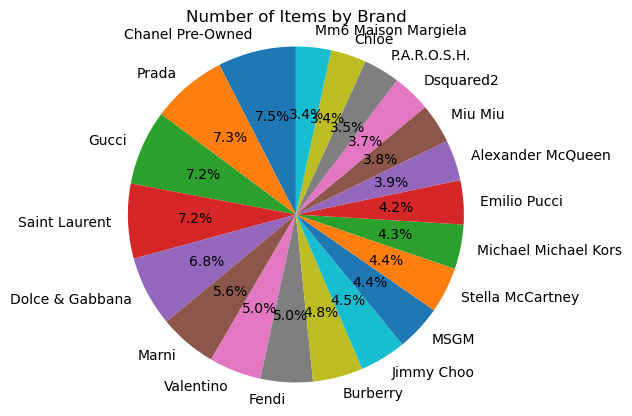

In [22]:
# Group by brand and calculate the count of items for each brand
brand_counts = listing_data['brand.name'].value_counts()
top_10_brands = brand_counts.nlargest(20)
# Plotting a pie chart for the number of items by brand
plt.pie(top_10_brands, labels=top_10_brands.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Number of Items by Brand')
plt.show()




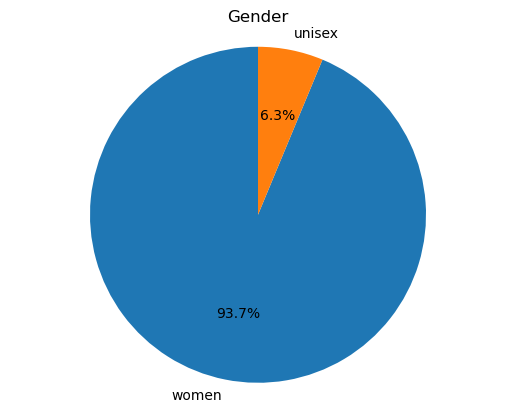

In [23]:
# Group by brand and calculate the count of items for each brand
brand_counts = listing_data['gender'].value_counts()
# top_10_brands = brand_counts.nlargest(20)
# Plotting a pie chart for the number of items by brand
plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.title('Gender')
plt.show()